In [25]:
# Import dependencies
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.automap import automap_base
import pandas as pd
from sqlalchemy.orm import Session
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns

**Adding a primary key to the sqlite table so that Automap can generate the base classes**

There does not seem to be a way to set a primary key in the pandas df.to_sql() method currently. 
However, a work around at the moment is: to duplicate the existing table in sqlite, set a primary key when creating the new table, copying the data from the old to the new table, and then dropping the old table
Referred from Stack Overflow: https://stackoverflow.com/questions/39407254/how-to-set-the-primary-key-when-writing-a-pandas-dataframe-to-a-sqlite-database

In [26]:
# Start connection
conn = sqlite3.connect('PlayerStats.sqlite')
c = conn.cursor()

In [27]:
# create a new table with the same column names and types as the existing tablem, while defining a primary key
c.executescript('''PRAGMA foreign_keys=off;

    BEGIN TRANSACTION;
    
    CREATE TABLE new_data (
    'index' INT PRIMARY KEY NOT NULL, 
    'Player' TEXT,
    'Pos' TEXT,
    'Age' BIGINT,
    'Tm' TEXT,
    'G' BIGINT,
    'GS' BIGINT,
    'MP' BIGINT,
    'FG' BIGINT,
    'FGA' BIGINT,
    'FG%' FLOAT,
    '3P' BIGINT,
    '3PA' BIGINT,
    '3P%' FLOAT,
    '2P' BIGINT,
    '2PA' BIGINT,
    '2P%' FLOAT,
    'eFG%' FLOAT,
    'FT' BIGINT,
    'FTA' BIGINT,
    'FT%' FLOAT,
    'ORB' BIGINT,
    'DRB' BIGINT,
    'TRB' BIGINT,
    'AST' BIGINT,
    'STL' BIGINT,
    'BLK' BIGINT,
    'TOV' BIGINT,
    'PF' BIGINT,
    'PTS' BIGINT,
    'Season' BIGINT,
    'Country' TEXT);

    INSERT INTO new_data SELECT * FROM data;

    DROP TABLE data;
    COMMIT TRANSACTION;

    PRAGMA foreign_keys=on;''')

OperationalError: table new_data already exists

In [28]:
# close out the connection
c.close()
conn.close()

In [29]:
# Create an engine for the sqlite database
engine = create_engine("sqlite:///PlayerStats.sqlite", echo=False)

In [30]:
# Reflect the Database using automap base
Base = automap_base()

In [31]:
Base.prepare(engine, reflect=True)

In [32]:
Base.classes.keys()

['new_data']

In [33]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['new_data']

In [34]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('new_data')
for x in columns:
    print(x['name'], x['type'])

index INTEGER
Player TEXT
Pos TEXT
Age BIGINT
Tm TEXT
G BIGINT
GS BIGINT
MP BIGINT
FG BIGINT
FGA BIGINT
FG% FLOAT
3P BIGINT
3PA BIGINT
3P% FLOAT
2P BIGINT
2PA BIGINT
2P% FLOAT
eFG% FLOAT
FT BIGINT
FTA BIGINT
FT% FLOAT
ORB BIGINT
DRB BIGINT
TRB BIGINT
AST BIGINT
STL BIGINT
BLK BIGINT
TOV BIGINT
PF BIGINT
PTS BIGINT
Season BIGINT
Country TEXT


In [35]:
session = Session(engine)

In [37]:
# Directly load the sqlite file to a dataframe using the read_sql function, in order to plot data
df = pd.read_sql("SELECT * FROM new_data", con=engine)
df.head()

,index,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,Country
0,0,Steven Adams,C,26,OKC,63,63,1680,283,478,...,376,583,146,51,67,94,122,684,2020,New Zealand
1,1,Bam Adebayo,PF,22,MIA,72,72,2417,440,790,...,559,735,368,82,93,204,182,1146,2020,United States
2,2,LaMarcus Aldridge,C,34,SAS,53,53,1754,391,793,...,289,392,129,36,87,74,128,1001,2020,United States
3,3,Kyle Alexander,C,23,MIA,2,0,13,1,2,...,1,3,0,0,0,1,1,2,2020,Canada
4,4,Nickeil Alexander-Walker,SG,21,NOP,47,1,591,98,266,...,75,84,89,17,8,54,57,267,2020,Canada


**Data Exploration & Visualization**
* Once we have loaded the data from the sqlite database into a DF, we can plot this data and come up with interesting visualizations

**Minutes played for each player across seasons**

In [38]:
# Reset the index 
df = df.set_index('Player')
df

,index,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,Country
Player,,,,,,,,,,,,,,,,,,,,,
Steven Adams,0,C,26,OKC,63,63,1680,283,478,0.592,...,376,583,146,51,67,94,122,684,2020,New Zealand
Bam Adebayo,1,PF,22,MIA,72,72,2417,440,790,0.557,...,559,735,368,82,93,204,182,1146,2020,United States
LaMarcus Aldridge,2,C,34,SAS,53,53,1754,391,793,0.493,...,289,392,129,36,87,74,128,1001,2020,United States
Kyle Alexander,3,C,23,MIA,2,0,13,1,2,0.500,...,1,3,0,0,0,1,1,2,2020,Canada
Nickeil Alexander-Walker,4,SG,21,NOP,47,1,591,98,266,0.368,...,75,84,89,17,8,54,57,267,2020,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Haywoode Workman,13559,PG,25,WSB,73,56,2034,234,515,0.454,...,191,242,353,87,7,135,162,581,1991,United States
James Worthy,13560,SF,29,LAL,78,74,3008,716,1455,0.492,...,249,356,275,104,35,127,117,1670,1991,United States
Howard Wright,13561,PF,23,TOT,15,0,164,19,47,0.404,...,33,45,3,4,5,11,28,54,1991,United States


In [39]:
player = input("Which player would you like to analyze? ")

Which player would you like to analyze? Steven Adams


In [40]:
mins = df.loc[player,['MP', 'Season']]
mins

,MP,Season
Player,,
Steven Adams,1680,2020
Steven Adams,2669,2019
Steven Adams,2487,2018
Steven Adams,2389,2017
Steven Adams,2014,2016
Steven Adams,1771,2015
Steven Adams,1197,2014


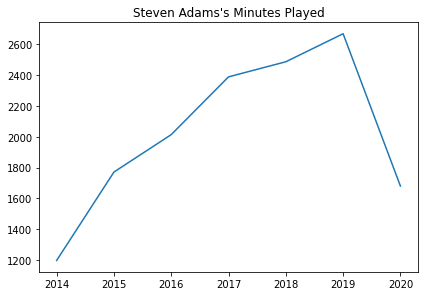

In [41]:
# Plot a line graph to track a player's minutes played across seasons played
plt.figure()
plt.plot(mins['Season'],mins['MP'])
plt.tight_layout()
plt.title(player + "'s Minutes Played")
plt.show()

**Top 10 Rebounders**

In [50]:
# Sort the players based on DRB - Defensive Rebounds
defensive_df = df.sort_values('DRB', ascending=False).nlargest(20, 'DRB', keep = 'first')
defensive_df = defensive_df.reset_index()

In [61]:
# Select the required columns for plotting 
defensive_df = defensive_df[['Player', 'DRB']]
grouped = defensive_df.groupby('Player') # groupby player name as players who have played in multiple years are repeated
final = grouped.sum().sort_values('DRB', ascending=True)
final

,DRB
Player,
Hassan Whiteside,795
Marcus Camby,807
Ben Wallace,833
Kevin Willis,840
Dikembe Mutombo,853
Dwight Howard,1680
Dennis Rodman,1921
Andre Drummond,2460
DeAndre Jordan,3279


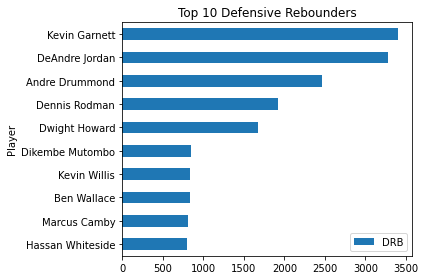

In [62]:
# Plot the dataframe as a horizontal bar chart
final.plot.barh(title="Top 10 Defensive Rebounders")
plt.tight_layout()
plt.show()